In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import sympy
from sympy import *
from operator import mul
from functools import reduce
import mpmath as mp
from mpmath import fac
import functools
from sympy import init_printing
from sympy.core.decorators import _sympifyit, call_highest_priority
from IPython.display import display_latex
init_printing()
import copy
import collections

In [2]:
class LieOperator(Expr):
    '''
    Defined algebra for the Lie operator:
    Addition: Hamiltonian functions get added into a new Lie operator
    Multiplication: Poisson bracket gets applied
    Exp: Lie Transfer Map gets applied
    BCH: Baker- Campbell - Hausdorff expansion gets applied as Lie Tranfer Map concatenation
    CAUTION: NOT ASSOCIATIVE

    INPUT: Hamiltonian, generalized coordinates and momenta
    '''
    
    
    _op_priority = 11.0

    is_commutative = False
    
    
    def __new__(cls, ham, indep_coords, indep_mom):
        if not isinstance(indep_coords, list): #create list of coords
            indep_coords = [indep_coords]
        if not isinstance(indep_mom, list): #create list of momenta
            indep_mom = [indep_mom]
        
        #same number of coordinates and momenta have to be entered
        assert(len(indep_coords)==len(indep_mom)),'The number of coords and momenta is not the same'
            
        obj = Expr.__new__(cls, ham, indep_coords, indep_mom)
        obj._ham = ham
        obj._indep_coords = indep_coords
        obj._indep_mom = indep_mom
        return obj
    
    
    @property
    def ham(self):
        return self._ham
    
    @ham.setter
    def ham(self, other):
        #Input has to be a function
        assert(not(S(ham.is_number))), 'Input has to be a function and not a number'
        self._ham = self._ham.subs(self.ham, other).doit()
        
    @property
    def indep_coords(self):
        return self._indep_coords
    
    @indep_coords.setter
    def indep_coords(self, other):
        self._indep_coords = other
        
    @property
    def indep_mom(self):
        return self._indep_mom
    
    @indep_mom.setter
    def indep_mom(self, other):
        self._indep_mom = other
        
        
        
    
    #Algebraic properties 

    #Define Addition
    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__radd__')
    def __add__(self,other):
        if not isinstance(other, LieOperator):
            raise TypeError(other, ' has to be a Lie Operator')
        elif not collections.Counter(self.indep_coords) == collections.Counter(other.indep_coords):
            raise TypeError('Lie Operators do not have the same dimension.')
        else:
            return LieOperator(self.ham + other.ham, self.indep_coords,self.indep_mom)

    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__add__')
    def __radd__(self,other):
        if not isinstance(other, LieOperator):
            raise TypeError(other, ' has to be a Lie Operator')
        elif not collections.Counter(self.indep_coords) == collections.Counter(other.indep_coords):
            raise TypeError('Lie Operators do not have the same dimension.')
        else:
            return LieOperator(self.ham + other.ham, self.indep_coords,self.indep_mom)
    
    #Define Substraction
    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__rsub__')
    def __sub__(self, other):
        if not isinstance(other, LieOperator):
            raise TypeError(other, ' has to be a Lie Operator')
        elif not collections.Counter(self.indep_coords) == collections.Counter(other.indep_coords):
            raise TypeError('Lie Operators do not have the same dimension.')
        else:
            return LieOperator(self.ham - other.ham, self.indep_coords,self.indep_mom)

    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__sub__')
    def __rsub__(self, other):
        if not isinstance(other, LieOperator):
            raise TypeError(other, ' has to be a Lie Operator')
        elif not collections.Counter(self.indep_coords) == collections.Counter(other.indep_coords):
            raise TypeError('Lie Operators do not have the same dimension.')
        else:
            return LieOperator(self.ham - other.ham, self.indep_coords,self.indep_mom)
        
    #Define Multiplication
    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__rmul__')
    def __mul__(self, other):
        return self.LieOperatorMul(other)
        
        
    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__mul__')
    def __rmul__(self,other):
        if S(other).is_number:
            return LieOperator(other*self.ham,self.indep_coords,self.indep_mom)
        elif not isinstance(other, LieOperator):
            other = LieOperator(other,self.indep_coords,self.indep_mom) 
        return other.LieOperatorMul(self)
    
    
    def LieOperatorMul(_ham1, _ham2):
        if not isinstance(_ham2, LieOperator):
            _ham2 = LieOperator(_ham2,_ham1.indep_coords,_ham1.indep_mom) 
        if not collections.Counter(_ham1.indep_coords) == collections.Counter(_ham2.indep_coords):
            raise TypeError('Lie Operators do not have the same dimension.')
        else:
            return _ham1.Poisson(_ham2)
    
    
    #Calcualte Poisson bracket with input function
    def Poisson(self,other):
        _h1 = self.ham
        _h2 = other.ham
        hp = S(0)
        for qi,pi in zip(self.indep_coords, self.indep_mom):
            hp += _h1.diff(qi) * _h2.diff(pi) 
            hp -= _h1.diff(pi) * _h2.diff(qi)
        return LieOperator(hp,self.indep_coords,self.indep_mom)
    
    
    #Exponential Map: Lie Transform Map
    #Calculate the exponential map of the Lie operator to the input cutoff
    def LieMap(self,other,power):
        s = S(0)
        
        for i in range(power+1):
            s += sympy.Rational(1,factorial(i))*(self.ExpPowerLieBracket(other,i)).ham
        
        return LieOperator(s,self.indep_coords,self.indep_mom) 
    
    
    
    #Successively apply Poisson bracket to input function to the input cutoff
    def ExpPowerLieBracket(self, other, power):
        _op1 = self
        _op2 = other
        
        
        if power > 0:
            hp = _op1*_op2
            
            for s in range(1,power):
                hp = _op1*hp
                
        else:
            if not isinstance(_op2, LieOperator):
                _op2 = LieOperator(_op2, self.indep_coords,self.indep_mom)
            
            hp = _op2
        
        return hp
    
    #Up to order 4 done manually to have a working copy, arbitrary ordered needs to be still written
    def BCH(self,other,n):
        if not isinstance(other, LieOperator):
            raise TypeError(other, ' has to be a Lie Operator')
        elif not collections.Counter(self.indep_coords) == collections.Counter(other.indep_coords):
            raise TypeError('Lie Operators do not have the same dimension.')
        elif n < 1:
            raise ValueError(n, ' is not a valid order. Number has to be natural.')
            
        _op1 = LieOperator(self.ham,self.indep_coords, self.indep_mom)
        _op2 = LieOperator(other.ham, other.indep_coords, other.indep_mom)
        
        
        temp = _op1 + _op2
        
        if n > 1:
            _xy = _op1 * _op2
            _yx = _op2 * _op1
            temp = temp + sympy.Rational(1,2) * _xy
        
        if n > 2:
            _xxy = _op1 * _xy
            _yyx = _op2 * _yx
            temp = temp + sympy.Rational(1,12) * _xxy + sympy.Rational(1,12) * _yyx
           
        if n > 3:
            _yxxy = _op2 * _xxy 
            temp = temp  - sympy.Rational(1,24) * _yxxy
        
        if n > 4:
            _xyxyx = _op1 * (_op2 * (_op1 * _yx))
            _yxyxy = _op2 * (_op1 * (_op2 * _xy))
            
            _xxxy = _op1 * _xxy
            _yyyx = _op2 * _yyx
            temp = temp + (sympy.Rational(1,120) * _xyxyx
                           + sympy.Rational(1,120) * _yxyxy
                           + sympy.Rational(1,360) * _op1 * _yyyx
                           + sympy.Rational(1,360) * _op2 * _xxxy
                           - sympy.Rational(1,720) * _op2 * _yyyx
                           - sympy.Rational(1,720) * _op1 * _xxxy
                          )
       
        return temp

In [3]:
x, y, z, px, py, pz, L, eps = sympy.symbols('x y z p_x p_y \delta L E')

In [4]:
def FODOMatrix(_l1,_l2,_l,_k1,_k2):
    #l1 focusing quad length
    #k1 focusing quad strength
    #l2 defocusing quad length
    #k2 defocusing quad strength
    #l drift length
    
    omegaf = np.sqrt(_k1)
    _sinf = np.sin(omegaf * _l1)
    _cosf = np.cos(omegaf * _l1)
    _sinhf = np.sinh(omegaf * _l1)
    _coshf = np.cosh(omegaf * _l1)

    _Mqf = np.array(
        [
            [_cosf, _sinf / omegaf, 0, 0],
            [-omegaf * _sinf, _cosf, 0, 0],
            [0, 0, _coshf, _sinhf / omegaf],
            [0, 0, omegaf * _sinhf, _coshf]
        ]
    )

    omegad = np.sqrt(_k2)
    _sind = np.sin(omegad * _l2)
    _cosd = np.cos(omegad * _l2)
    _sinhd = np.sinh(omegad * _l2)
    _coshd = np.cosh(omegad * _l2)
    
    
    
    _Mqd = np.array(
        [
            [_coshd,_sinhd / omegad, 0, 0],
            [omegad * _sinhd, _coshd, 0, 0],
            [0, 0, _cosd, _sind / omegad],
            [0, 0, -omegad * _sind, _cosd]
        ]
    )


    _Md = np.array(
        [
            [1,_l,0,0],
            [0,1,0,0],
            [0,0,1,_l],
            [0,0,0,1]
        ]
    )

    _M = np.dot(_Md,_Mqf)
    _M = np.dot(_Mqd,_M)
    _M = np.dot(_Md,_M)
    _M = np.dot(_Mqf,_M)
    
    return _M

In [5]:
R = FODOMatrix(0.25,0.5,2.5,0.54102,0.54102)
r0 = np.array([10e-5,0,10e-4,0])
dataMATRICES = [r0]

duration = 1000

for i in range(duration):
    r = np.dot(R,r0)
    dataMATRICES.append(r)
    r0 = np.copy(r)

dataMATRICES = np.array(dataMATRICES)

In [6]:
def drift(r,l,delta=0):
    _x = r[0]
    _px = r[1]
    _y = r[2]
    _py = r[3]
    
    xn = _x + l * _px / np.sqrt((1+delta)**2 - _px**2 - _py**2)
    pxn = _px
    yn = _y + l * _py / np.sqrt((1+delta)**2 - _px**2 - _py**2)
    pyn = _py
    
    return xn, pxn, yn, pyn

In [7]:
_l1 = 0.25
_l2 = 0.5
_l = 2.5
_k1 = 0.54102
_k2 = 0.54102
_delta = 0.0001

omegaf = np.sqrt(_k1)
_sinf = np.sin(omegaf * _l1)
_cosf = np.cos(omegaf * _l1)
_sinhf = np.sinh(omegaf * _l1)
_coshf = np.cosh(omegaf * _l1)

_Mqf = np.array(
    [
        [_cosf, _sinf / omegaf, 0, 0],
        [-omegaf * _sinf, _cosf, 0, 0],
        [0, 0, _coshf, _sinhf / omegaf],
        [0, 0, omegaf * _sinhf, _coshf]
    ]
)

omegad = np.sqrt(_k2)
_sind = np.sin(omegad * _l2)
_cosd = np.cos(omegad * _l2)
_sinhd = np.sinh(omegad * _l2)
_coshd = np.cosh(omegad * _l2)



_Mqd = np.array(
    [
        [_coshd,_sinhd / omegad, 0, 0],
        [omegad * _sinhd, _coshd, 0, 0],
        [0, 0, _cosd, _sind / omegad],
        [0, 0, -omegad * _sind, _cosd]
    ]
)


r0 = np.array([10e-5,0,10e-4,0])
dataFULL = [r0]

duration = 1000

for i in range(duration):
    r = np.dot(_Mqf,r0)
    r = drift(r,_l,_delta)
    r = np.dot(_Mqd,r)
    r = drift(r,_l,_delta)
    r = np.dot(_Mqf,r)
    
    dataFULL.append(r)
    r0 = np.copy(r)

dataFULL = np.array(dataFULL)

In [8]:
delta = _delta
g = sympy.sqrt((1+pz)**2 - px**2 - py**2) 
l_dyn = LieOperator(_l * g.subs(px,px*eps).subs(py,py*eps).subs(pz,pz*eps).series(eps,n=4).removeO().subs(eps,1).subs(pz, delta),[x,y],[px,py])
l_all = LieOperator(_l * g.subs(px,px*eps).subs(py,py*eps).series(eps,n=4).removeO().subs(eps,1).subs(pz,delta),[x,y],[px,py])
d = (1 + pz)
H = (px**2)/(2*d) + (py**2)/(2*d) - d
l_wol = LieOperator(-_l * H.subs(pz,delta),[x,y],[px,py])

In [9]:
g.subs(px,px*eps).subs(py,py*eps).subs(pz,pz*eps).series(eps,n=4).removeO().subs(eps,1)

In [10]:
l_dyn.LieMap(x,5)

In [11]:
l_dyn.LieMap(px,5)

In [12]:
l_dyn.LieMap(y,5)

In [13]:
l_dyn.LieMap(py,5)

In [14]:
l_all.LieMap(x,5)

In [15]:
l_all.LieMap(px,5)

In [16]:
l_all.LieMap(y,5)

In [17]:
l_all.LieMap(py,5)

In [18]:
l_wol.LieMap(x,5)

In [19]:
l_wol.LieMap(px,5)

In [20]:
l_wol.LieMap(y,5)

In [21]:
l_wol.LieMap(py,5)

In [22]:
def drift_all(r,l):
    _x = r[0]
    _px = r[1]
    _y = r[2]
    _py = r[3]
    
    
    xn = l_dyn.LieMap(x,5).ham.subs(x,_x).subs(px,_px).subs(y,_y).subs(py,_py)
    pxn = l_dyn.LieMap(px,5).ham.subs(x,_x).subs(px,_px).subs(y,_y).subs(py,_py)
    yn = l_dyn.LieMap(y,5).ham.subs(x,_x).subs(px,_px).subs(y,_y).subs(py,_py)
    pyn = l_dyn.LieMap(py,5).ham.subs(x,_x).subs(px,_px).subs(y,_y).subs(py,_py)
    
    return xn, pxn, yn, pyn

In [23]:
def drift_dyn(r,l):
    _x = r[0]
    _px = r[1]
    _y = r[2]
    _py = r[3]
    
    xn = l_all.LieMap(x,5).ham.subs(x,_x).subs(px,_px).subs(y,_y).subs(py,_py)
    pxn = l_all.LieMap(px,5).ham.subs(x,_x).subs(px,_px).subs(y,_y).subs(py,_py)
    yn = l_all.LieMap(y,5).ham.subs(x,_x).subs(px,_px).subs(y,_y).subs(py,_py)
    pyn = l_all.LieMap(py,5).ham.subs(x,_x).subs(px,_px).subs(y,_y).subs(py,_py)
    
    return xn, pxn, yn, pyn

In [24]:
def drift_wolski(r,l):
    _x = r[0]
    _px = r[1]
    _y = r[2]
    _py = r[3]
    
    
    
    xn = l_wol.LieMap(x,5).ham.subs(x,_x).subs(px,_px).subs(y,_y).subs(py,_py)
    pxn = l_wol.LieMap(px,5).ham.subs(x,_x).subs(px,_px).subs(y,_y).subs(py,_py)
    yn = l_wol.LieMap(y,5).ham.subs(x,_x).subs(px,_px).subs(y,_y).subs(py,_py)
    pyn = l_wol.LieMap(py,5).ham.subs(x,_x).subs(px,_px).subs(y,_y).subs(py,_py)
    
    return xn, pxn, yn, pyn

In [25]:
r0 = np.array([10e-5,0,10e-4,0])
dataWOLSKI = [r0]

duration = 1000

for i in range(duration):
    r = np.dot(_Mqf,r0)
    r = drift_wolski(r,_l)
    r = np.dot(_Mqd,r)
    r = drift_wolski(r,_l)
    r = np.dot(_Mqf,r)
    
    dataWOLSKI.append(r)
    r0 = np.copy(r)

dataWOLSKI = np.array(dataWOLSKI)

In [26]:
r0 = np.array([10e-5,0,10e-4,0])
dataDYN = [r0]

duration = 1000

for i in range(duration):
    r = np.dot(_Mqf,r0)
    r = drift_dyn(r,_l)
    r = np.dot(_Mqd,r)
    r = drift_dyn(r,_l)
    r = np.dot(_Mqf,r)
    
    dataDYN.append(r)
    r0 = np.copy(r)

dataDYN = np.array(dataDYN)

In [27]:
r0 = np.array([10e-5,0,10e-4,0])
dataALL = [r0]

duration = 1000

for i in range(duration):
    r = np.dot(_Mqf,r0)
    r = drift_all(r,_l)
    r = np.dot(_Mqd,r)
    r = drift_all(r,_l)
    r = np.dot(_Mqf,r)
    
    dataALL.append(r)
    r0 = np.copy(r)

dataALL = np.array(dataALL)

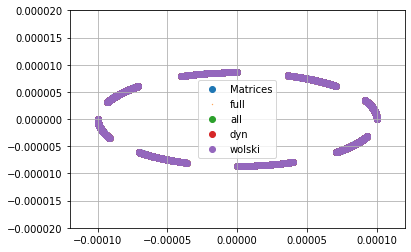

In [28]:
plt.scatter(dataMATRICES[:,0],dataMATRICES[:,1],label='Matrices')
plt.scatter(dataFULL[:,0],dataFULL[:,1],s=0.1,label='full')
plt.scatter(dataALL[:,0],dataALL[:,1],label='all')
plt.scatter(dataDYN[:,0],dataDYN[:,1],label='dyn')
plt.scatter(dataWOLSKI[:,0],dataWOLSKI[:,1],label='wolski')


plt.grid()
plt.xlim(-0.00012,0.00012);
plt.ylim(-0.00002,0.00002);
plt.legend();

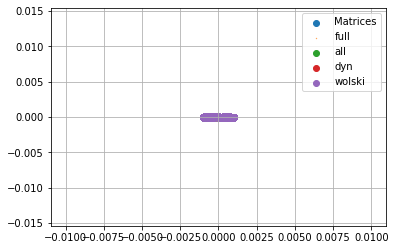

In [29]:
plt.scatter(dataMATRICES[:,2],dataMATRICES[:,3],label='Matrices')
plt.scatter(dataFULL[:,2],dataFULL[:,3],s=0.1,label='full')
plt.scatter(dataALL[:,2],dataALL[:,3],label='all')
plt.scatter(dataDYN[:,2],dataDYN[:,3],label='dyn')
plt.scatter(dataWOLSKI[:,2],dataWOLSKI[:,3],label='wolski')


plt.grid()
# plt.xlim(-0.0025,0.0025);
# plt.ylim(-0.0003,0.0003);
plt.legend();